Copyright 2024 Google LLC. Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

In [ ]:
import ee

ee.Authenticate()

In [ ]:
#@markdown Specify Earth Engine project id.
PROJECT_ID = ''  # @param {type:"string"}
ee.Initialize(project=PROJECT_ID)

# Load data from Google Earth Engine

In [ ]:
# Load and filter zip code feature collection
zips = ee.FeatureCollection('TIGER/2010/ZCTA5').filter(ee.Filter.lt("ALAND10", 10130491060))
print('num zips:', zips.size().getInfo())

num zips: 33098


In [ ]:
# Filter for contiguous US
contiguous_us = ee.Geometry.Rectangle([-127.18, 19.39, -62.75, 51.29])
zips = zips.filterBounds(contiguous_us)
print('contiguous US zips:', zips.size().getInfo())

contiguous US zips: 32655


In [ ]:
nighttime_lights = ee.ImageCollection('NOAA/VIIRS/DNB/ANNUAL_V22').select('median').median()  # 500m resolution

In [ ]:
def summarize_region(feature):
  feature = feature.simplify(50)

  def process_geometries(geometry):
    geometry = ee.Geometry(geometry)
    return ee.Algorithms.If(
        ee.String(geometry.type()).compareTo('Polygon'), None, geometry
    )

  if feature.geometry().type() != 'Polygon':
    filtered_geoms = (
        feature.geometry()
        .geometries()
        .map(process_geometries)
        .filter(ee.Filter.notNull(['item']))
    )
    feature = feature.setGeometry(ee.Geometry.MultiPolygon(filtered_geoms))

  # Clip datasets to feature
  lights = nighttime_lights.clip(feature.geometry()).reduceRegion(
      reducer=ee.Reducer.mean(), scale=500, maxPixels=1e9
  )

  # Set the computed values to the feature
  feature = feature.set({
      'night_lights': lights.get('median'),
  })
  return feature


# Polling function to check task status
def poll_task(task, task_name, interval=120):
  print(f'Polling {task_name} task...')
  while task.active():
    print(f"{task_name} task status: {task.status()['state']}")
    time.sleep(interval)
  final_status = task.status()['state']
  print(f'{task_name} task completed with status: {final_status}')

In [ ]:
data = zips.map(summarize_region)

In [ ]:
# Export results to drive
export_drive_task = ee.batch.Export.table.toDrive(
    collection=data,
    description='zipcode_environmental_simplified',
    folder='content',
    fileFormat='GeoJSON'
)
export_drive_task.start()

In [ ]:
import time
poll_task(export_drive_task, "Export to Drive")

Polling Export to Drive task...
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task status: RUNNING
Export to Drive task completed with status: COMPLETED


# Using PDFM Embeddings and Nightime lights in a prediction task

## Download a csv file of the embeddings using this [link](https://docs.google.com/forms/d/e/1FAIpQLSeZLIqTCIx1-OiBzUnqXZpu_k5M223ZvMmqwQhMZ_0TkaWhEQ/viewform).

The county and ZCTA (zipcode census tabulation area) embeddings are available in different files.

Here we assume that you have obtained the embeddings and uploaded them to a Google Drive directory called `pdfm_embeddings/v0/us`.

In [ ]:
import pandas as pd
from google.colab import drive
#@markdown Specify the path to the embeddings file.
embeddings_file_path = '/content/drive/MyDrive/content/us/zcta_embeddings.csv' #@param {type:"string"}

drive.mount('/content/drive', force_remount=True)
zipcode_embeddings = pd.read_csv(embeddings_file_path).set_index('place')

Mounted at /content/drive


In [ ]:
zipcode_embeddings.head(2)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329
place,,,,,,,,,,,,,,,,,,,,,
zip/97910,OR,Malheur County,609,42.749076,-117.511459,-0.138227,1.120377,0.072900,0.297442,0.772673,...,-0.158891,-0.168708,1.231994,-0.155765,3.043214,-0.169749,0.177463,-0.001661,-0.001010,4.495589
zip/89412,NV,Washoe County,98,41.102934,-119.695361,-0.141379,1.422782,0.234269,0.159156,0.890241,...,-0.157417,-0.043606,2.788701,-0.062547,3.700745,-0.169827,-0.137990,-0.024385,-0.000295,3.399393


In [ ]:
embedding_features = [f'feature{x}' for x in range(330)]

## Load the night time lights data

In [ ]:
import geopandas as gpd

nighttime_lights_gdf = gpd.read_file('/content/drive/MyDrive/content/zipcode_environmental_simplified.geojson')
nighttime_lights_gdf['ZCTA5CE10'] =  nighttime_lights_gdf['ZCTA5CE10'].apply(lambda x: f'zip/{x}')
nighttime_lights_gdf.set_index('ZCTA5CE10', inplace=True)
nighttime_lights_gdf.index.name = 'place'

In [ ]:
nighttime_lights_gdf.head(2)


,id,ALAND10,AWATER10,CLASSFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,night_lights,geometry
place,,,,,,,,,,,
zip/54724,00000000000000000000,412780448,5567589,B5,S,54724,+45.1062481,-091.4875884,G6350,0.822285,"POLYGON ((-91.66667 45.10438, -91.66631 45.104..."
zip/54725,00000000000000000001,258657150,1018253,B5,S,54725,+45.0732125,-091.9909561,G6350,0.633084,"POLYGON ((-92.11662 45.07126, -92.10621 45.071..."


In [ ]:
nighttime_lights_df = pd.DataFrame({'place': nighttime_lights_gdf.index, 'night_lights': nighttime_lights_gdf['night_lights']}).reset_index(drop=True)
nighttime_lights_df.set_index('place', inplace=True)

## Visualization

In [ ]:
def get_locale(df, index, states=None, counties=None):
  df = df[df.index.isin(index)]
  if not states and not counties:
    return df
  filter = df.state.isin(states)
  if counties:
    filter &= df.county.isin(counties)
  return df[filter]

In [ ]:
df = zipcode_embeddings.join(nighttime_lights_gdf)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [ ]:
feature = 'night_lights'
state = 'NY'

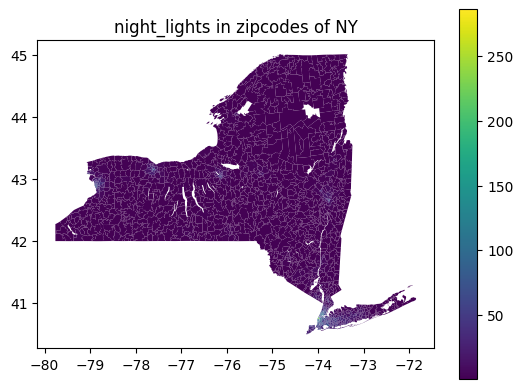

In [ ]:
ax = get_locale(gdf, zipcode_embeddings.index, states=[state]).plot(feature, legend=True)
_ = ax.set_title(feature + ' in zipcodes of NY')

# Modelling

In [ ]:
from sklearn import metrics as skmetrics
import math
import matplotlib.pyplot as plt

def evaluate(df: pd.DataFrame) -> dict[float]:
  """Evaluates the model performance on the given dataframe.

  Args:
    df: A pandas DataFrame with columns 'y' and 'y_pred'.
  Returns:
    A dictionary of performance metrics.
  """

  df = df.dropna(subset='y')
  df = df[df.y != 0]
  r2 = skmetrics.r2_score(df.y, df.y_pred)
  r = df['y'].corr(df['y_pred'])
  rmse = math.sqrt(skmetrics.mean_squared_error(df.y, df.y_pred))
  mae = skmetrics.mean_absolute_error(df.y, df.y_pred)
  mape = skmetrics.mean_absolute_percentage_error(df.y, df.y_pred)
  return {'r2': r2, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r': r}



def plot_actual_vs_predicted(df: pd.DataFrame):
    """Plots actual vs. predicted values to visualize model performance.

    Args:
      df: A pandas DataFrame with columns 'y' and 'y_pred'.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(df['y'], df['y_pred'], alpha=0.5)
    plt.plot([df['y'].min(), df['y'].max()], [df['y'].min(), df['y'].max()], 'r--', linewidth=2)  # Reference line
    plt.xlabel('Actual Values (y)')
    plt.ylabel('Predicted Values (y_pred)')
    plt.title('Actual vs. Predicted Values')
    plt.grid(True)
    plt.show()

{'r2': 0.8374889203272997, 'rmse': 7.331514159521307, 'mae': 3.7628626369335567, 'mape': 1.9766126040439616, 'r': 0.9152662534343912}


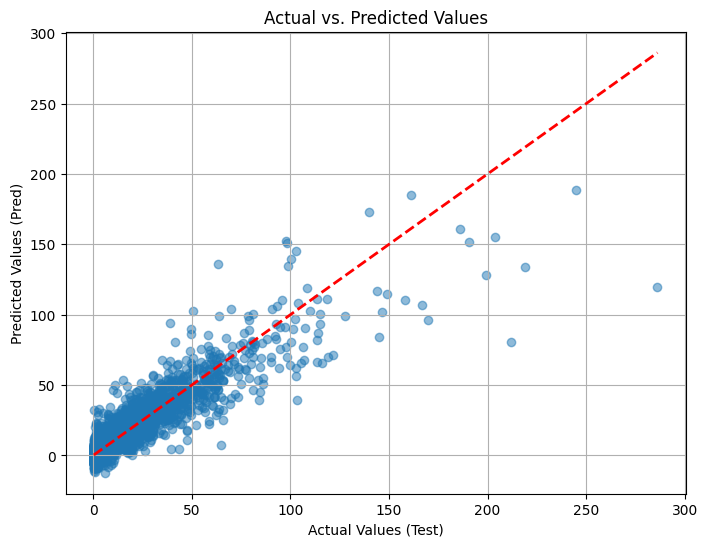

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data = zipcode_embeddings.merge(nighttime_lights_df, left_index=True, right_index=True)
label = 'night_lights'

X = data[embedding_features]
y = data[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

evaluation_df = pd.DataFrame({'y': y_test, 'y_pred': y_pred})
# Evaluate the model
metrics = evaluate(evaluation_df)
print(metrics)
plot_actual_vs_predicted(evaluation_df)


{'r2': 0.7904310907533483, 'rmse': 8.325601434031825, 'mae': 2.7668561291602534, 'mape': 0.4020218100058125, 'r': 0.8936492002020289}


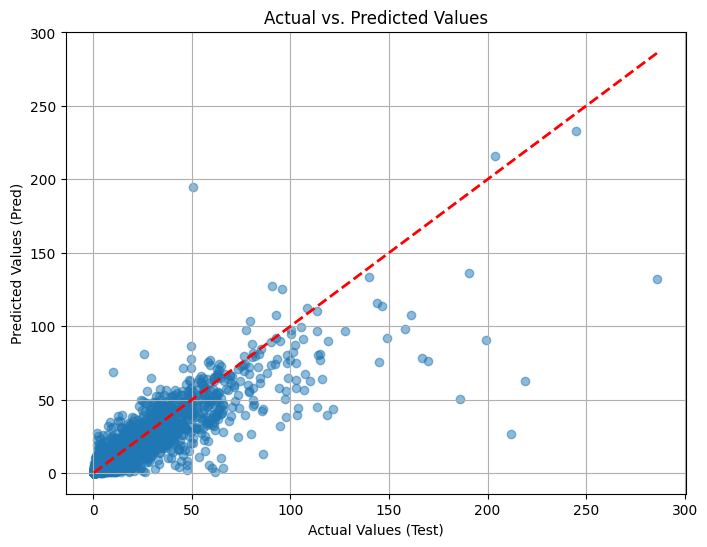

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

k = 5
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

evaluation_df = pd.DataFrame({'y': y_test, 'y_pred': y_pred})
# Evaluate the model
metrics = evaluate(evaluation_df)
print(metrics)
plot_actual_vs_predicted(evaluation_df)